# Projeto AM 2018-1, Questão 2
Professor: Francisco de A. T. de Carvalho<br>
Equipe:<br>
<ul>
    <li>Cleison Amorim</li>
    <li>Dennys Azevedo</li>
    <li>Dinaldo Pessoa</li>
</ul>
Centro de Informática, CIn/UFPE

# Introdução

Conforme [enunciado do projeto](http://www.cin.ufpe.br/~fatc/AM/Projeto-AM-2018-1.pdf), essa questão trata de um problema de classificação multiclasse. Sete imagens de ambientes externos foram utilizadas para geração dos exemplos. Cada exemplo correponde a uma região de 3x3 pixels de uma das imagens. Os exemplos foram rotulados segundo as seguintes classes: BRICKFACE, SKY, FOLIAGE, CEMENT, WINDOW, PATH, GRASS. As variáveis dos exemplos são informações de formas e cores extraídas da região de pixeis. Em outras palavras, os classificadores usarão informações de textura ao invés de usar diretamente os valores de RGB dos nove pixels da região.

O objetivo deste trabalho é comparar diversas combinações de classificadores e visões das variáveis em relação à taxa de acerto.

Esse documento foi estruturado da seguinte forma: [Introdução](#Introdução), traz uma breve explicação do problema tratado, do objetivo do trabalho e prepara o contexto de execução da análise dos dados e do experimento; [Conhecendo os dados](#Conhecendo-os-dados), faz uma análise exploratória dos dados e realiza a seleção de variáveis; [Execução do experimento](#Execução-do-experimento), define a semente do estado aleatório, monta as combinações de classificadores e visões das variáveis e executa o experimento; [Avaliação dos resultados individuais](#Avaliação-dos-resultados-individuais), avalia as médias e os intervalos de confiança das taxas de acerto das combinações; e [Comparação dos classificadores](#Comparação-dos-classificadores), realiza os testes de Friedman e Nemenyi para identificar as combinações com resultados significativamente diferentes.

## Contexto de execução
### Dependências

In [18]:
import logging as log
import math as ma
import pprint as pp
import numpy as np
import pandas as pd
import transformer as tr
import parzen as pa
import result as rs
from sklearn import naive_bayes as nb
from sklearn import pipeline as pi
from sklearn import model_selection as ms
from sklearn import ensemble as en
import scipy.stats as st
import Orange as og
import matplotlib.pyplot as plt

### Log

In [19]:
logger = log.getLogger('logger')
logger.setLevel(log.DEBUG)
# sklearn só gera log quando nível é DEBUG ou INFO
verbose = max((log.WARNING - logger.getEffectiveLevel()), 0)

# Conhecendo os dados

## Leiaute


Conforme enunciado, as variáveis do conjunto de dados foram divididas em duas visões:<br>
<ul>
    <li>Shape view: as primeiras 9 variáveis;</li>
    <li>RGB view: as 10 últimas variáveis.</li>
<ul>

Observando a amostra abaixo, foi verificado que o rótulo se encontra na coluna mais à esquerda e as demais colunas são as variáveis. Mais detalhes sobre as variáveis podem ser obtidos na documentação do conjunto de dados [Image Segmentation](http://archive.ics.uci.edu/ml/machine-learning-databases/image/segmentation.names).

In [20]:
# carrega dados
data = pd.read_csv('segmentation.test', skiprows=[0,1,2,4])
# move os dados de rótulo para uma coluna
data = data.reset_index()
# renomeia coluna do rótulo
data = data.rename(index=str, columns={'index': 'LABEL'})
data.head(3)

,LABEL,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN
0,GRASS,110.0,189.0,9,0.0,0.0,1.000000,0.666667,1.222222,1.186342,12.925926,10.888889,9.222222,18.666668,-6.111111,-11.111111,17.222221,18.666668,0.508139,1.910864
1,GRASS,86.0,187.0,9,0.0,0.0,1.111111,0.720082,1.444444,0.750309,13.740741,11.666667,10.333334,19.222221,-6.222222,-10.222222,16.444445,19.222221,0.463329,1.941465
2,GRASS,225.0,244.0,9,0.0,0.0,3.388889,2.195113,3.000000,1.520234,12.259259,10.333334,9.333334,17.111110,-5.777778,-8.777778,14.555555,17.111110,0.480149,1.987902


Antes de passar os dados para os classificadores, é preciso confirmar que os tipos das variáveis são numéricos. A tabela abaixo confirma isso, pois os tipos das variáveis se limitam a float64 e int64. Além disso, a semântica das variáveis nos garante que não há dados categóricos. Conforme documetação do conjunto de dados, todas as variáveis são números ordinais. Nesse caso, as variáveis já estão em formatos compatíveis com os classificadores que serão usados mais à frente, sem a necessidade de pré-processamento.

In [21]:
data.dtypes

LABEL                    object
REGION-CENTROID-COL     float64
REGION-CENTROID-ROW     float64
REGION-PIXEL-COUNT        int64
SHORT-LINE-DENSITY-5    float64
SHORT-LINE-DENSITY-2    float64
VEDGE-MEAN              float64
VEDGE-SD                float64
HEDGE-MEAN              float64
HEDGE-SD                float64
INTENSITY-MEAN          float64
RAWRED-MEAN             float64
RAWBLUE-MEAN            float64
RAWGREEN-MEAN           float64
EXRED-MEAN              float64
EXBLUE-MEAN             float64
EXGREEN-MEAN            float64
VALUE-MEAN              float64
SATURATION-MEAN         float64
HUE-MEAN                float64
dtype: object

## Estatísticas

A tabela abaixo mostra propriedades estatísticas das variáveis. Cada coluna corresponde a uma variável e cada linha corresponde a uma propriedade. A partir das propriedades min (mínimo), max (máximo) e mean (média), é possível ver que as variáves não estão na mesma escala e nem possuem a mesma média. Porém, isso não foi um problema para os classificadores que foram usados no experimento. Os classificadores bayesiano gaussiano (GaussianNB) e bayesiano baseado em janela de Parzen com função de kernel gaussiana (ParzenWindowB) são robustos às diferenças de escala entre as variáveis.

In [22]:
data.describe()

,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN
count,2100.000000,2100.000000,2100.0,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2.100000e+03,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,124.940476,123.483333,9.0,0.014921,0.004550,1.890820,5.708299,2.406772,7.904224e+00,37.047654,32.806667,44.205556,34.130741,-12.722963,21.473704,-8.750741,45.162381,0.427259,-1.365147
std,72.858637,57.431428,0.0,0.041024,0.023573,2.649453,44.989359,3.469954,5.347107e+01,38.135291,34.994538,43.510119,36.303768,11.588214,19.654107,11.606996,42.900582,0.228458,1.544278
min,1.000000,11.000000,9.0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.589457e-08,0.000000,0.000000,0.000000,0.000000,-49.666668,-12.444445,-33.888890,0.000000,0.000000,-3.044175
25%,62.000000,81.000000,9.0,0.000000,0.000000,0.722222,0.349603,0.833332,4.216377e-01,7.472222,7.000000,9.666667,6.222222,-18.583333,4.305556,-17.000000,11.777778,0.284934,-2.188539
50%,121.000000,122.000000,9.0,0.000000,0.000000,1.277776,0.833333,1.444444,9.897442e-01,21.666666,19.666668,27.777779,20.444445,-10.888889,19.666666,-11.000000,28.666666,0.375064,-2.052625
75%,188.250000,171.250000,9.0,0.000000,0.000000,2.222221,1.807406,2.555556,2.251852e+00,53.277778,47.333332,65.000000,46.388888,-4.222222,36.111110,-3.222222,65.000000,0.540228,-1.565745
max,254.000000,251.000000,9.0,0.333333,0.222222,29.222221,991.718400,44.722225,1.386329e+03,143.444440,137.111110,150.888890,142.555560,9.888889,82.000000,24.666666,150.888890,1.000000,2.912480


## Seleção de variáveis

A partir da propriedade std (desvio padrão) da tabela acima, também é possível verificar que a variável REGION-PIXEL-COUNT é a constante 9. Isso a torna irrelevante para os classificadores e até criou complicações na execução do experimento, como divisão por zero na validação cruzada que define o tamanho da janela de Parzen. Por isso, ela foi excluída do conjunto de dados com o comando abaixo.

In [23]:
data = data.drop(columns=['REGION-PIXEL-COUNT'])

# Execução do experimento

O experimento consiste em executar a validação cruzada estratificada "30 times 10-fold" para cada combinação de classificador e visão das variáveis e para o classificador combinado. Para isso, vários passos de preparação foram realizados antes da validação cruzada propriamente dita dos classificadores. Todos os passos serão descritos a seguir:

## Preparação

1) Define uma semente para estado aleatório do experimento.

In [24]:
# dez primeiros dígitos de pi
seed = round(ma.pi * 10**9)
seed

3141592654

2) Separa o rótulo das variáveis.

In [25]:
# variáveis
X = data[data.columns[1:]]
# rótulo
y = data['LABEL']

3) Cria o classificador combinado. Conforme enunciado, esse classificador consiste na combinação de seis combinações de visões e classificadores com a regra da soma:
<ul>
    <li>Complete view e GaussianNB;</li>
    <li>Shape view e GaussianNB;</li>
    <li>RGB view e GaussianNB;</li>
    <li>Complete view e ParzenWindowB;</li>
    <li>Shape view e ParzenWindowB;</li>
    <li>RGB view e ParzenWindowB.</li>
</ul>
Mais detalhes sobre a regra de combinação podem ser obtidos na documentação de [VotingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) [\[3\]](#ref3) e no artigo [\[2\]](#ref2).

In [26]:
# define as opções para as combinações de visões e classificadores
param_grid = {'a_view': [tr.CompleteView(), tr.ShapeView(), tr.RgbView()],
              'b_clf': [nb.GaussianNB(), pa.ParzenWindowB()]}
# monta pipelines de todas as combinações
all_steps = list(map(lambda params: list(params.items()), ms.ParameterGrid(param_grid)))
pipelines = list(map(lambda steps: ('clf'+str(all_steps.index(steps)), pi.Pipeline(steps)), all_steps))
# classificador combinado com regra da média (equivalente a regra )
combined = en.VotingClassifier(estimators=pipelines, voting='soft')

4) Define dicionários dos nomes das visões e dos classificadores. Esses nomes serão vistos mais à frente, pois foram utilizados na formatação dos resultados.

In [27]:
views = {tr.CompleteView(): 'comp',
        tr.ShapeView(): 'shape',
        tr.RgbView(): 'rgb'}
clfs = {nb.GaussianNB(): 'gnb',
        pa.ParzenWindowB(): 'pwb'}
clf_combined = {combined: 'combined'}

5) Une dicionários de nomes em um único dicionário.

In [28]:
names = dict(views)
names.update(clfs)
names.update(clf_combined)

## Validação cruzada

Executa a validação cruzada extratificada com cada combinação de visão e classificador simples e com o classificador combinado. Conforme enunciado da questão, as visões das variáveis são complete, shape e rgb e os classificadores simples são bayesiano gaussiano e bayesiano baseado em janela de Parzen. Devido à diferença na estrutura do pipeline, o classificador combinado foi criado na seção [Preparação](#Preparação) e incluído de forma isolada no experimento para evitar novas combinações com as visões.

In [ ]:
# limpa cache do tamanho da janela de Parzen (bandwidth)
#pa.BandwidthOptimizer().clear_cache()

# os passos abaixo definem apenas a estrutura do pipeline
# o primeiro passo define a visão das variáveis
# o segundo passo define o classificador simples.
steps = [('a_view', tr.CompleteView()),
         ('b_clf', nb.GaussianNB())]
pipe = pi.Pipeline(steps)

# o grid de parâmetros abaixo define todas as opções de visões e classificadores simples para combinação 
# e define a opção isolada do classificador combinado
param_grid = [{'a_view': list(views.keys()),
               'b_clf': list(clfs.keys())},
              {'b_clf': list(clf_combined.keys())}
             ]
# a busca em grid repete o experimento 30 vezes para cada combinação de parâmetros
grid_search = ms.GridSearchCV(pipe, param_grid=param_grid, cv=ms.RepeatedStratifiedKFold(n_splits=10,n_repeats=30,random_state=seed),verbose=verbose,return_train_score=False)
grid_search.fit(X, y);

In [30]:
logger.debug(pp.pformat(grid_search.cv_results_))

### Classificadores utilizados

O classificador bayesiano gaussiano utiliado assume que as variáveis seguem uma distribuição normal multivariada e são independentes. Além disso, desconsidera as probabilidades a priori, já que o conjunto de dados possui uma distribuição uniforme entre as classes. Então, na etapa de treinamento, uma função de distribuição de probalidade condicional é estimada para cada classe com base na forma paramétrica de uma função de distribuiçao normal multivariada. Na etapa de classificaçao, para cada classe, uma probabilidade a posteriori é calculada com base na função de densidade de probabilidade condicional da respectiva classe. Por fim, o exemplo é dito como da classe com maior probabilidade a posteriori. Mais detalhes sobre o classificador bayesiano gaussiano podem ser obtidos na documentação de [GaussianNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) [\[3\]](#ref3).

O classificador bayesiano baseado em janela de Parzen utilizado não assume a forma de distribuição das variáveis e não assume que elas são independentes. Além disso, a função de janela foi substituída por uma função de kernel gaussiana. Assim como o classificador bayesiano gaussiano, esse classificador desconsidera as probabilidades a priori. Então, na etapa de treinamento, os dados são apenas carregados. Na etapa de classificação, esse classificador utiliza a regra do produto para combinar as funções de kernel gaussianas das variáveis e obter o resultado da função de densidade de probabilidade condicional de cada classe. Com esses valores, ele calcula as probabilidades a posteriori de cada classe. Por fim, o exemplo é dito como da classe com maior probabilidade a posteriori.  Mais detalhes sobre o classificador bayesiano baseado em janela de Parzen com função de kernel gaussiana podem ser obtidos no código fonte de [ParzenWindowB](./parzen.py) e na documentação de [KDEMultivariate](o classificador bayesiano baseado em janela de Parzen com função de kernel gaussiana).

### Tamanho da janela de Parzen

Vale salientar que o classificador ParzenWindowB faz um validação cruzada interna para encontrar o melhor tamanho de janela para o conjunto de dados de treinamento de cada rodada de validação cruzada do experimento. Os valores avaliados na validação cruzada interna são 3, 4 e 5.

Mais detalhes sobre a definição do tamanho da janela de Parzen podem ser obtidos no código fonte de [BandwidthOptimizer](./parzen.py).

### Tempo de execução

Em um computador com Processador Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz, 2 Núcleo(s), 2,0 GB de Memória RAM, a execução da validação cruzada levou 260,2 min (por volta de 4 h). Foi verificado que a validação cruzada para definição do tamanho da janela de Parzen introduz bastante custo computacional e ela ocorre de forma idêntica nos classificadores simples e no combinado. Então, para evitar o recálculo desses valores dentro de uma mesma validação cruzada ou em reexecuções completas, foi introduzido um mecanismo de cache em BandwidthOptimizer. Essa otimização baixou o tempo de reexecução para 11,0 min. Porém, o tempo de execução de ParzenWindowB ainda permaneceu relativamente elevado. Enquanto que, utilizando todas as variáveis, GaussianNB executa uma rodada de validação cruzada em um tempo na ordem de 10^-3 s, ParzenWindowB fica na ordem de 10^1 s (sem cache) e 10^-1 s (com cache). Esse resultado é um indício de que ParzenWindowB, sem otimizações adicionais, pode não ser uma boa opção para um contexto que exige alta performance computacional.

### Reprodução

Todo código fonte utilizado se encontra disponível em um repositorio do [GitHub](https://github.com/amorim-cleison/cin_am/). Além disso, um ambiente de execução similar ao do experimento se encontra disponível no [Binder](https://mybinder.org/v2/gh/amorim-cleison/cin_am/develop?filepath=questao_2%2Fquestao2.ipynb).

## Avaliação dos resultados individuais

Esta seção tem o objetivo de formatar os dados gerados pelo experimento, obter uma estimativa pontual e um intervalo de confiança para a taxa de acerto de cada classificador.

### Formatação dos dados

Os dados gerados pelo experimento que são relevantes para este trabalho consistem em uma matriz no formato "rodada de validação cruzada" x "classificador" (300 x 7), com um valor de "taxa de acerto" em cada célula. Porém, conforme orientado, é preciso calcular a média da taxa de acerto para cada repetição da validação cruzada antes de seguir em frente. Dessa forma, a nova matriz, exibida abaixo, ficou no formato "repetição" x "classificador" (30 x 7), com uma média da "taxa de acerto" em cada célula. Cada repetição corresponde a 10 rodadas de validação cruzada, pois a divisão do conjunto de dados é 10-fold. Vide a seção [Preparação](#Preparação) para obter o dicionário de nomes das abreviaçoes referenciadas na matriz abaixo.

In [31]:
result = rs.ResultFormatter(names=names, n_splits=10).format(grid_search.cv_results_)
result

repetition,comp_gnb,comp_pwb,shape_gnb,shape_pwb,rgb_gnb,rgb_pwb,combined
0,0.798095,0.950952,0.478571,0.586190,0.794286,0.869048,0.937619
1,0.795714,0.951429,0.471905,0.583810,0.795238,0.867143,0.933810
2,0.796667,0.954286,0.479048,0.587143,0.790476,0.873333,0.936667
3,0.799048,0.954762,0.473333,0.581905,0.794762,0.871905,0.938571
4,0.794762,0.950000,0.479048,0.586667,0.800000,0.869524,0.938095
5,0.799048,0.953333,0.477143,0.588095,0.795238,0.870952,0.933810
6,0.795714,0.949048,0.477143,0.582857,0.792381,0.866667,0.936190
7,0.796190,0.951429,0.474286,0.589524,0.795238,0.868571,0.930000
8,0.796667,0.953333,0.473810,0.585238,0.798095,0.867619,0.935714
9,0.799048,0.954286,0.475714,0.587619,0.796667,0.870952,0.936667


### Estimativa pontual e intervalo de confiança

A tabela abaixo contém os resultados individuais dos classificadores. "score_mean" é a estimativa pontual da média da taxa de acerto e "confidence_interval" é o intervalo no qual há 95% confiança de que o "score_mean" esteja presente. Como a amostra utilizada para cálcular "score_mean" é de tamanho 30, é possível assumir que a distribuição de "score_mean" se aproxima de uma distribuição normal, conforme afirma o Teorema do Limite Central. Com base nesse tipo de distribuição, foi calculado o intervalo de confiança da estimativa pontual. A combinação "comp_pwb" (Complete view e ParzenWindowB) foi o classificador que obteve o melhor resultado.

In [32]:
estimate = result.apply(st.bayes_mvs, alpha=0.95)
estimate = pd.DataFrame.from_records(estimate.T.tolist(), index=estimate.index.rename('clf'), columns=['score_mean', 'variance', 'std_dev'])
estimate = pd.DataFrame.from_records(estimate['score_mean'].tolist(), index=estimate.index, columns=['score_mean', 'confidence_interval'])
estimate

,score_mean,confidence_interval
clf,,
comp_gnb,0.796857,"(0.796384152991, 0.797330132723)"
comp_pwb,0.952159,"(0.95140761877, 0.952909841548)"
shape_gnb,0.476127,"(0.475321249765, 0.476932718489)"
shape_pwb,0.586143,"(0.584677061536, 0.58760865275)"
rgb_gnb,0.795317,"(0.794500505578, 0.796134415057)"
rgb_pwb,0.869524,"(0.868781066783, 0.870266552264)"
combined,0.935571,"(0.934791244694, 0.936351612449)"


## Comparação dos classificadores

Os classificadores foram comparados por meio de um teste estatístico para confirmar que a diferença entre eles é significante. O teste utilizado foi o teste de Friedman. A hipótese nula foi: as médias das taxas de acerto dos classificadores no conjunto de dados "Imagem Segmentation" possuem a mesma distribuição, ou seja, as diferenças entre os classificadores para o conjunto de dados utilizado são insignificantes. A hipótese alternativa foi: as diferenças entre os classificadores para o conjunto de dados utilizado são estatisticamente significantes.

Mais detalhes sobre comparação de classificadores podem ser obtidos no artigo [\[1\]](#ref1). Vale salientar que esse artigo utilizou vários conjuntos de dados, enquanto que este trabalho utilizou apenas um. Dessa forma, a comparação de classificadores realizada neste trabalho está limitada ao conjunto de dados Image Segmentation, não podendo ser generalizada para outros cenários. Se a hipótese nula deste trabalho fosse generalizada, o risco de cometer o erro Tipo 1 seria elevado, pois as variâncias das médias das taxas de acerto dependem unicamente da amostragem de dados de cada repetição da validação cruzada. Nesse caso, as chances da performance do melhor classificador da primeira repetição de validação cruzada se manter nas demais repetições é muito alta.

O teste de Friedman foi realizado e o p-value é exibido abaixo. O resultado do teste foi a rejeição da hipótese nula com p-value < 0.05.

In [33]:
measurements = np.asarray(result.T)
test_stat, p_value = st.friedmanchisquare(*measurements)
p_value

9.4194712315349006e-36

Dado que a hipótese nula foi rejeitada, o passo seguinte foi aplicar o teste de Nemenyi para identificar quais pares de classificadores possuem diferenças significativas e quais não possuem. O resultado do teste é exibido abaixo de forma gráfica, com o CD diagram [\[1\]](#ref2) (diagrama de diferença crítica), com p-value < 0.05. A partir desse diagrama, é possível observar que, por exemplo, "comp_pwb" e "combined" não possuem diferenças significativas, pois estão conectados por uma barra; enquanto que "comp_pwb" e "rgb_pwb" possuem diferenças significativas, pois não estão conectados por uma barra. A ordenação dos classificadores é do melhor resultado (esquerda) para o pior (direita). Por fim, a barra acima do gráfico com a sigla CD representa a diferença crítica para p-value < 0.05.

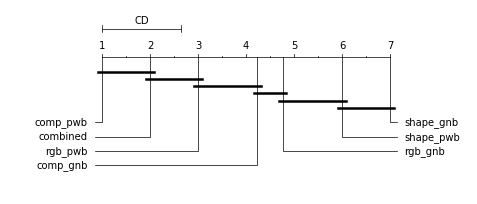

In [34]:
avg_rank = result.rank(axis=1, ascending=False)
avg_rank = avg_rank.mean()
cd = og.evaluation.compute_CD(avranks=avg_rank, n=len(result), alpha='0.05', test='nemenyi')
og.evaluation.graph_ranks(avranks=avg_rank, names=result.columns, cd=cd)
plt.show()

# Conclusão

A partir dos resultados individuais e das comparações dos classificadores, é possível concluir que "comp_pwb" possui a melhor estimativa pontual de média de taxa de acerto, mas a comparação dos classificadores não confirma diferença significativa entre esse classificador e "combined". Por outro lado, como "combined" é a junção de seis combinações de visões e classicadores e "comp_pwb" é um classificador simples, o segundo classificador torna-se a melhor opção quando o custo computacional é um dos critérios de escolha. Por fim, vale reforçar que essas conclusões se limitam ao conjunto de dados utilizado, Image Segmentation.

# Referências bibliográficas

<ol>
    <li id="ref1">DEMŠAR, Janez. <a href="http://www.cin.ufpe.br/~fatc/AM/demsar06.pdf">Statistical comparisons of classifiers over multiple data sets</a>. Journal of Machine learning research, v. 7, n. Jan, p. 1-30, 2006.</li>
    <li id="ref2">KITTLER, Josef et al. <a href="http://www.cin.ufpe.br/~fatc/AM/KittlerEtAl-IEEE-PAMI-1998.pdf">On combining classifiers</a>. IEEE transactions on pattern analysis and machine intelligence, v. 20, n. 3, p. 226-239, 1998.</li>
    <li id="ref3">PEDREGOSA, Fabian et al. <a href="http://www.jmlr.org/papers/volume12/pedregosa11a/pedregosa11a.pdf">Scikit-learn: Machine learning in Python</a>. Journal of machine learning research, v. 12, n. Oct, p. 2825-2830, 2011.</li>
</ol>